In [1]:
#import pandas as pd
import os
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing


import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Useful Functions

#Encode a numeric column as z_Score
def encode_num_zscore(df,name, mean=None, sd=None):
    if mean is None:
        mean=df[name].mean()
        
    if sd is None:
        sd=df[name].std()
        
    df[name]=(df[name]-mean)/sd  
    
#Encode text values to dummy variables ([1,0,0],[0,1,0],[0,0,1])        
def encode_text_dummy(df,name):
    dummies=pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name]=dummies[x]
    df.drop(name, axis=1,inplace=True)
    
#Convert a Pandas dataframe into the x,y inputs the Tensor Flow needs
def tensor_flow_xy(df, target):
    result=[]
    for x in df.columns:
        if x!=target:
            result.append(x)
    #find out the type of the target column
    target_type =df[target].dtypes
    target_type=target_type[0] if hasattr(target_type, '__iter__') else target_type
    #Encode to int for classification, float otherwise
    if target_type in (np.int64, np.int32):
        #Classification
        dummies=pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        #Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
#Convert all missing text values to mode
def missin_text_mode(df,name):
    mod=df[name].mode()
    df[name]=df[name].fillna(mod)
    
#Convert all missing values to median
def missin_median(df,name):
    med=df[name].median()
    df[name]=df[name].fillna(med)

#Convert all missing values to default_value
def missin_median(df,name,default_value):
    df[name]=df[name].fillna(default_value)

# Import training data as train
train = pd.read_csv("train_ajEneEa.csv")
print('Train: ', train.shape)
# Import testing data as test
test = pd.read_csv("test_v2akXPA.csv")
print('Test: ', test.shape)
train[0:5]

Train:  (43400, 12)
Test:  (18601, 11)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [17]:
test[0:5]
#print(train.head(5))
#train_length = len(train)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [18]:
print(train.dtypes)
df=train.describe()
train.describe()

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


hypertension      0     1    All
stroke                          
0             38756  3861  42617
1               583   200    783
All           39339  4061  43400
0.4608294930875576

gender  Female   Male  Other    All
stroke                             
0        25234  17372     11  42617
1          431    352      0    783
All      25665  17724     11  43400
0.9930875576036866

work_type  Govt_job  Never_worked  Private  Self-employed  children    All
stroke                                                                    
0              5351           177    24393           6542      6154  42617
1                89             0      441            251         2    783
All            5440           177    24834           6793      6156  43400
1.0161290322580645

smoking_status  formerly smoked  never smoked  smokes    All
stroke                                                      
0                          7272         15769    6429  29470
1                           221      

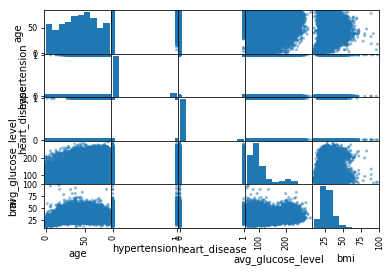

In [8]:


from pandas.plotting import scatter_matrix

allst=43400
cm=pd.crosstab(train['stroke'], train['hypertension'],margins=True)
print(cm)
print(100*(200/allst)) #"{0:.000%}".format((200/43400)))
print('')
cmg=pd.crosstab(train['stroke'], train['gender'],margins=True)
print(cmg)
print(100*(431/allst))
print('')
cmag=pd.crosstab(train['stroke'], train['work_type'],margins=True)
print(cmag)
print(100*(441/allst))
print('')
cmgl=pd.crosstab(train['stroke'], train['smoking_status'],margins=True)
print(cmgl)
print(100*(284/allst))
print('')
cmmer=pd.crosstab(train['stroke'], train['ever_married'],margins=True)
print(cmmer)
print(100*(703/allst))
print('')

print('Correlation')
print('')
print('Hypertention vc Heart',"{0:.0%}".format(train['hypertension'].corr(train['heart_disease'])))
print('Hypertention vc Glucose',"{0:.0%}".format(train['hypertension'].corr(train['avg_glucose_level'])))
print('Hypertention vc Age',"{0:.0%}".format(train['hypertension'].corr(train['age'])))
print('Hypertention vc BMI',"{0:.0%}".format(train['hypertension'].corr(train['bmi'])))

print('BMI vc Glucose',"{0:.0%}".format(train['bmi'].corr(train['avg_glucose_level'])))
print('Age vc Glucose',"{0:.0%}".format(train['age'].corr(train['avg_glucose_level'])))
print('Heart vc Glucose',"{0:.0%}".format(train['heart_disease'].corr(train['avg_glucose_level'])))

print('BMI vc stroke',"{0:.0%}".format(train['bmi'].corr(train['stroke'])))
print('BMI vc Age',"{0:.0%}".format(train['bmi'].corr(train['age'])))

print('Heart vc Age',"{0:.0%}".format(train['heart_disease'].corr(train['age'])))
scatter_matrix(train.iloc[:,2:10])
plt.show()

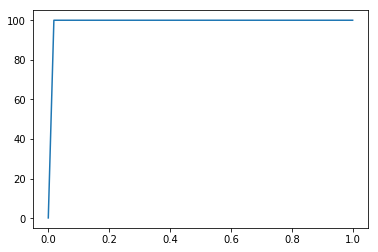

Test Sample
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object
id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   591
smoking_status       5751
dtype: int64


,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,18601.000000,18601.000000,18601.000000,18601.000000,18601.000000,18010.000000
mean,36747.368045,42.056504,0.093167,0.048062,104.386359,28.545325
std,21053.151124,22.528018,0.290674,0.213903,42.606714,7.757092
min,2.000000,0.080000,0.000000,0.000000,55.000000,10.200000
25%,18542.000000,24.000000,0.000000,0.000000,77.550000,23.300000
50%,36717.000000,43.000000,0.000000,0.000000,91.830000,27.700000
75%,55114.000000,60.000000,0.000000,0.000000,112.310000,32.800000
max,72942.000000,82.000000,1.000000,1.000000,275.720000,88.300000


In [8]:

str_sort=sorted(train['stroke'],reverse=True)

out=np.cumsum(str_sort, axis=0).astype("float64")
out/=out.max()
out*=100
#y=np.hstack((0,out))
x=np.arange(1, len(out)+1)/len(out)
#x=np.linspace(train['bmi'].min(),train['bmi'].max(), len(out))
plt.plot(x,out)
plt.show()

print('Test Sample')
print(test.dtypes)
dftest=test.describe()

print(test.isnull().sum())
test.describe()


In [9]:
from scipy.stats import mode

df=pd.DataFrame(train)
print(df.mode())
dft=pd.DataFrame(test)
print(dft.mode())

dft['smoking_status']=dft['smoking_status'].fillna(dft['smoking_status'].mode()[0])
dft['bmi']=dft['bmi'].fillna(dft['bmi'].mean())
print('Test Data after Fillinf: ', dft.apply(lambda x: sum(x.isnull())))


df['smoking_status']=df['smoking_status'].fillna(df['smoking_status'].mode()[0])
df['bmi']=df['bmi'].fillna(df['bmi'].mean())
print('Train Data after Filling: ', df.apply(lambda x: sum(x.isnull())))

          id  gender   age  hypertension  heart_disease ever_married  \
0          1  Female  51.0           0.0            0.0          Yes   
1          4     NaN   NaN           NaN            NaN          NaN   
2          6     NaN   NaN           NaN            NaN          NaN   
3          7     NaN   NaN           NaN            NaN          NaN   
4          8     NaN   NaN           NaN            NaN          NaN   
5          9     NaN   NaN           NaN            NaN          NaN   
6         10     NaN   NaN           NaN            NaN          NaN   
7         11     NaN   NaN           NaN            NaN          NaN   
8         12     NaN   NaN           NaN            NaN          NaN   
9         14     NaN   NaN           NaN            NaN          NaN   
10        15     NaN   NaN           NaN            NaN          NaN   
11        20     NaN   NaN           NaN            NaN          NaN   
12        22     NaN   NaN           NaN            NaN         

In [10]:
df.drop('id', axis=1, inplace=True)
dft.drop('id', axis=1, inplace=True)
print(df.dtypes)
print(dft.dtypes)
#print(df['smoking_status'].mode()[0])
#print(df['bmi'].mean())

from sklearn.preprocessing import LabelEncoder
cat_values = df.dtypes.loc[train.dtypes=='object'].index
cat_values_t = dft.dtypes.loc[train.dtypes=='object'].index
print(cat_values)
print(cat_values_t)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object
Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')
Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [11]:

le = LabelEncoder()
for cat in cat_values:
   df[cat]=le.fit_transform(df[cat])
   dft[cat]=le.fit_transform(dft[cat])
print('Train Data: ', df.dtypes)
print('Test Data: ', dft.dtypes)


Train Data:  gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object
Test Data:  gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
dtype: object


In [13]:
from sklearn.model_selection import train_test_split
import h5py
from sklearn import metrics

#Set the desired TensorFlow output Level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

def transform_df(df, target):
    result=[]
    for x in df.columns:
        if x!=target:
            result.append(x)
    target_type =df[target].dtypes
    target_type =target_type[0] if hasattr(target_type, '__iter__')else target_type
    #encode to int for classification, float otherwise. TensorFlow works with 32 bit
    if target_type in (np.int64, np.int32):
        
        #classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        #regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

stroketr=df['stroke']
num_classes=len(stroketr)
print(num_classes)

X,y=transform_df(df,'stroke')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)
print(X_test.shape[1])
print(y_test.shape[1])

#https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
#Create Model
#==============
model=Sequential()
model.add(Dense(20,input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

#Compile Model
#===============
model.compile(loss='categorical_crossentropy',optimizer='adam') #categorical_crossentropy

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=0,mode='auto')
#checkpointer = ModelCheckpoint(filepath='best_weights.hdf5',verbose=0,save_best_only=True) #save best model

#Fit the Model
#===============
#model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

#model.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=0,epochs=140)

#model.fit(X_train,y_train,verbose=0,epochs=1000)
scoreev = model.evaluate(X_test,y_test)
#model.load_weghts('best_weights.hdf5') # load weights from the model
print('Accuracy: {}'.format(scoreev))
#Measure accuracy
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
y_compare=np.argmax(y_test,axis=1)
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
score = metrics.accuracy_score(y_compare,pred)
print('Final accuracy: {}'.format(score))

#model.save(os.path.join(path,'network.h5'))

43400
10
2
10850/10850 [==============================] - 0s 18us/step
Accuracy: 0.0845926846508881
Final accuracy: 0.9808294930875576


In [15]:
#10850/10850 [==============================] - 0s 30us/step
#Accuracy: 0.08860515472311783
#Final accuracy: 0.9807373271889401

#10850/10850 [==============================] - 0s 16us/step
#Accuracy: 0.08245857213791202
#Final accuracy: 0.9808294930875576
    
#def transf(ser):
#    return ser/float(ser[-1])
#cm1=cm.apply(transf, axis=1)
#print(cm1)
from IPython.display import display

#Do not display numpy in scientific notation
np.set_printoptions(precision = 4)
np.set_printoptions(suppress=True)

#Generate the predictions
pred1=model.predict(X_test)
print('Preditions')
print(pred1[0]*100)

print('As percent probability')
display(pred[0:3])

score1=metrics.log_loss(y_test,pred1)
print('Log loss score: {}'.format(score1))

print(train.groupby('stroke').size())

Preditions
[95.7475  4.2525]
As percent probability


array([0, 0, 0], dtype=int64)

Log loss score: 0.08459268401470699
stroke
0    42617
1      783
dtype: int64


In [47]:
pred_test=model.predict(dft)
pred_test[0:5]

array([[9.0614986e-01, 9.3850121e-02],
       [9.0539354e-01, 9.4606489e-02],
       [9.9999499e-01, 5.0662461e-06],
       [9.9984801e-01, 1.5195781e-04],
       [9.8875976e-01, 1.1240294e-02]], dtype=float32)

In [ ]:
#Predict Output
predicted= model.predict(x_test)

#Reverse encoding for predicted outcome
predicted = number.inverse_transform(predicted)

#Store it to test dataset
test_modified['Loan_Status']=predicted
#Output file to make submission
test_modified.to_csv("Submission1.csv",columns=['_ID','Stroke'])

In [42]:
train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

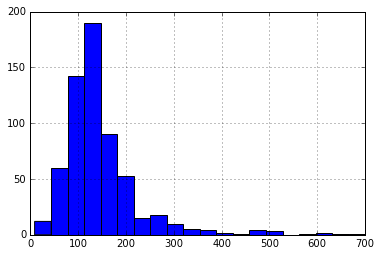

In [44]:
train['LoanAmount'].hist(bins=20)

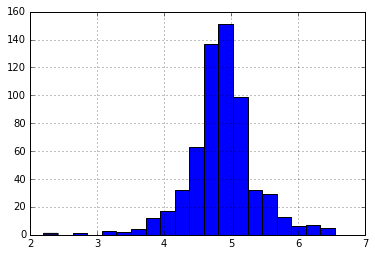

In [45]:

train['LoanAmount_log']=np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

In [47]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
cat_val=train.dtypes.loc[train.dtypes=='object'].index
print(cat_val)
for cat in cat_val:
    train[cat]=le.fit_transform(train[cat].astype(str))
print(train.dtypes)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


TypeError: unorderable types: str() > float()